- ネットワーク: 完全ネットワーク
- 変動: 2準位モデル

In [1]:
using Random: MersenneTwister, shuffle
using StatsBase: mean, std, sample, Weights
using Plots: plot, plot!, Plot

include("../src/Simulation.jl")
using Main.Simulation: Strategy, C, D, invert, sigmoid_fitness

In [2]:
"""
expectation:`e`、amplitude:`a`、wavelength:`λ`、time steps:`t_max`の2準位の波`Vector{Int}`を返す。
"""
function two_level_N_vec(e::Int, a::Int, λ::Int, t_max::Int)::Vector{Int}
    e .+ a .* [((x - 1) % λ) < (λ / 2) ?  -1 : 1 for x in 1:t_max]
end

@kwdef struct Param
    N_0::Int = 100
    T::Float64 = 1.1            # Temptation payoff
    S::Float64 = -0.1           # Sucker's payoff
    reproduction_rate::Float64 = 0.05
    a::Int = 10                 # amplitude
    λ::Int = 100                # wavelength
    δ::Float64 = 1.0            # strength of selection
    μ::Float64 = 0.01           # mutatino rate
    t_max::Int = 1_000          # time steps
    trial_max::Int = 100
    rng::MersenneTwister = MersenneTwister() # random seed
end

mutable struct Model
    param::Param
    t::Int    # time step
    payoff_table::Dict
    N_vec::Vector{Int}

    # agent's parameters
    strategy_vec::Vector{Strategy}     # agents' strategy
    payoff_vec::Vector{Float64}        # agents' payoff

    function Model(param::Param)
        N_vec = two_level_N_vec(param.N_0, param.a, param.λ, param.t_max + 1)
        
        new(
            param,
            1,
            Dict((C, C) => (1.0, 1.0), (C, D) => (param.S, param.T), (D, C) => (param.T, param.S), (D, D) => (0.0, 0.0)),
            N_vec,

            # agent's parameters
            rand(param.rng, [C, D], N_vec[1]),
            fill(0.0, N_vec[1])
        )
    end
end

cooperation_rate(model::Model)::Float64 = sum(model.strategy_vec .== C) / length(model.strategy_vec)

param_to_tuple(param::Param)::Tuple = param.N_0, param.T, param.S, param.reproduction_rate, param.δ, param.μ, param.t_max, param.trial_max

param_to_str(param::Param)::String = join(param_to_tuple(param), ", ")

function interaction!(model::Model, rng::MersenneTwister)::Nothing
    model.payoff_vec .= 0.0
    N = model.N_vec[model.t]
    focal_id_vec = collect(1:N)
    opponent_id_vec = shuffle(rng, 1:N)

    for (focal_id, opponent_id) in zip(focal_id_vec, opponent_id_vec)
        if focal_id == opponent_id
            opponent_id = (opponent_id + 1) % N + 1
        end

        # strategy
        strategy_pair = (model.strategy_vec[focal_id], model.strategy_vec[opponent_id])

        # payoff
        focal_payoff, opponent_payoff = model.payoff_table[strategy_pair]
        model.payoff_vec[focal_id] += focal_payoff
        model.payoff_vec[opponent_id] += opponent_payoff
    end

    return
end

function pick_agents_by_fitness(model::Model, n::Int, rng::MersenneTwister, select_for::Symbol)::Vector{Int}
    fitness_vec = if select_for == :death
        sigmoid_fitness.(-model.payoff_vec, model.param.δ)
    elseif select_for == :birth
        sigmoid_fitness.(model.payoff_vec, model.param.δ)
    else
        error("Invalid selection criteria: $(select_for). Use :death or :birth.")
    end

    agent_id_vec = try
        sample(rng, 1:length(fitness_vec), Weights(fitness_vec), n, replace = false)
    catch e
        @show n, fitness_vec
        throw(e)
    end
    
    return sort(agent_id_vec)
end

function death_birth!(model::Model, rng::MersenneTwister)::Tuple{Vector{Int}, Vector{Int}}
    n_death = n_birth = round(Int, model.N_vec[model.t] * model.param.reproduction_rate)
    n_growth = model.N_vec[model.t + 1] - model.N_vec[model.t]
    if n_growth > 0
        n_birth += n_growth
    elseif n_growth < 0
        n_death += abs(n_growth)
    end

    # death
    death_id_vec = pick_agents_by_fitness(model, n_death, rng, :death)
    deleteat!(model.strategy_vec, death_id_vec)
    deleteat!(model.payoff_vec, death_id_vec)

    # birth
    parent_id_vec = try 
        pick_agents_by_fitness(model, n_birth, rng, :birth)
    catch e
        @show model.N_vec[model.t], model.N_vec[model.t + 1], n_growth, n_death, n_birth
        e
    end
    append!(model.payoff_vec, zeros(Float64, n_birth))

    ## strategy
    mutate_vec = rand(rng, n_birth) .< model.param.μ
    strategy_vec = model.strategy_vec[parent_id_vec]
    strategy_vec = [mutate ? invert(strategy) : strategy for (strategy, mutate) in zip(strategy_vec, mutate_vec)]
    append!(model.strategy_vec, strategy_vec)

    return parent_id_vec, death_id_vec
end

function run_one_step!(model::Model)::Nothing
    interaction!(model, model.param.rng)
    death_birth!(model, model.param.rng)
    model.t += 1
    return
end

function run(param::Param)::Matrix{Float64}
    cooperation_rate_matrix = fill(0.0, param.t_max, param.trial_max)

    for trial in 1:param.trial_max
        model = Model(param)
        for t in 1:model.param.t_max
            run_one_step!(model)
            cooperation_rate_matrix[t, trial] = cooperation_rate(model)
        end
    end

    return cooperation_rate_matrix
end

function plot_time_series(cooperation_rate_matrix::Matrix{Float64}, title = "")::Plot
    t_max, trial_max = size(cooperation_rate_matrix)

    p = plot(size = (1000, 200), xlim = (0, t_max), xticks = 0:100:t_max, ylim = (0, 1), yticks = 0:0.1:1, legend = false, title = title)
    
    for trial in 1:trial_max
        plot!(cooperation_rate_matrix[:, trial])
    end
    
    plot!(mean(cooperation_rate_matrix, dims=2), lc = :black, lw = 3)
    
    return p
end;

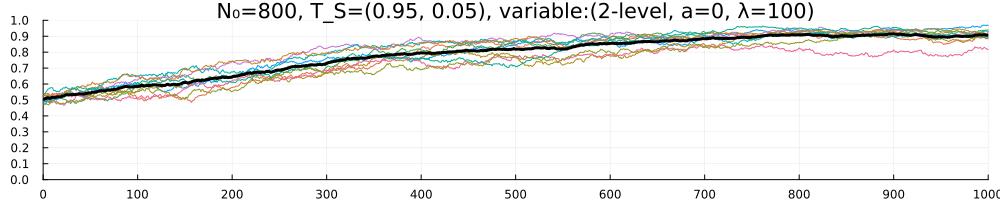

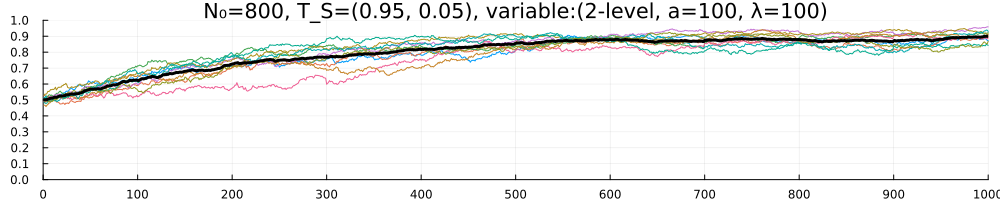

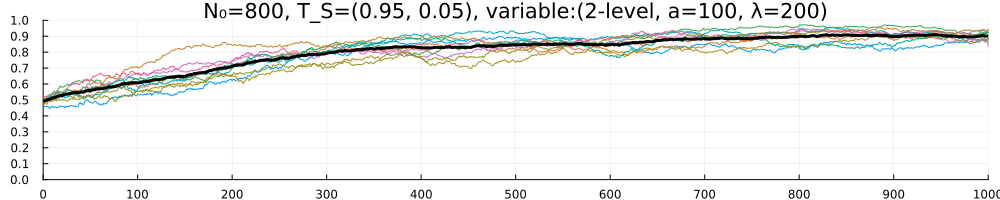

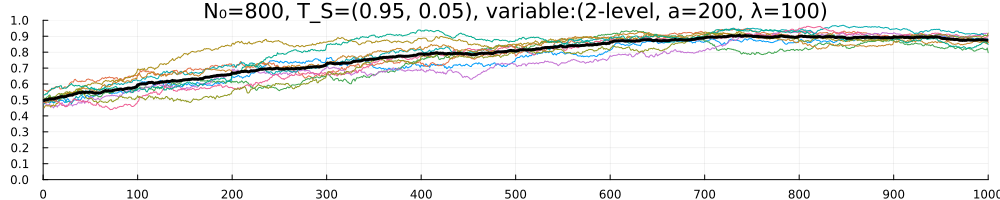

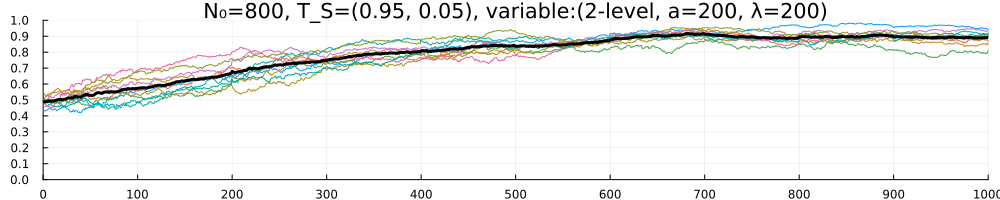

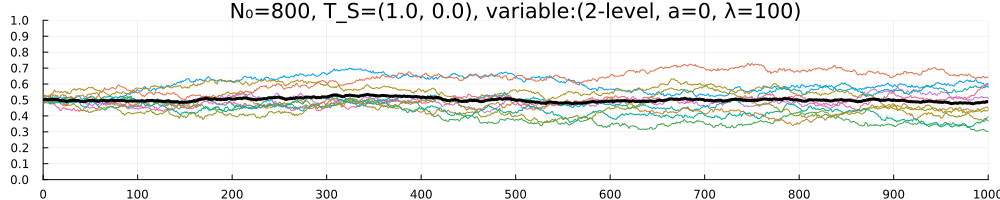

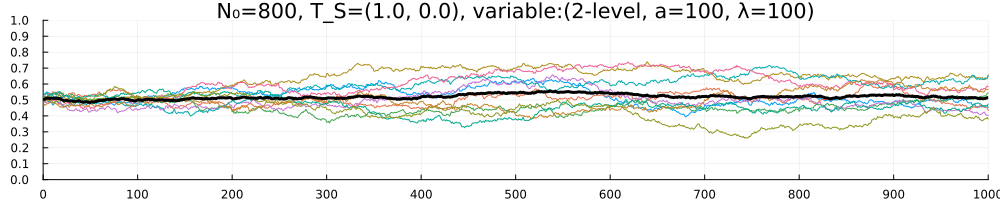

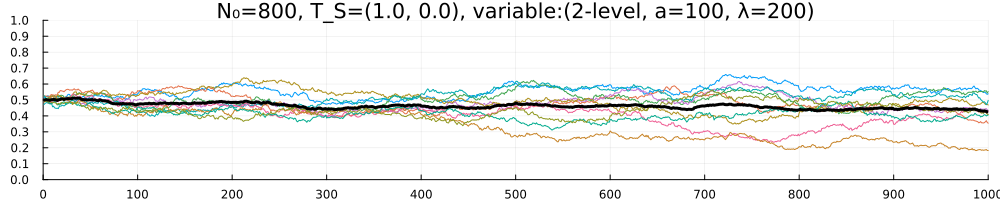

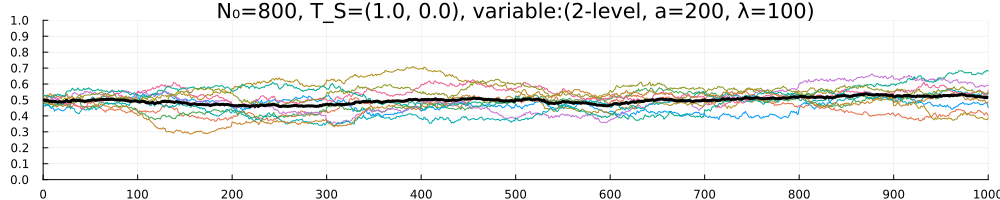

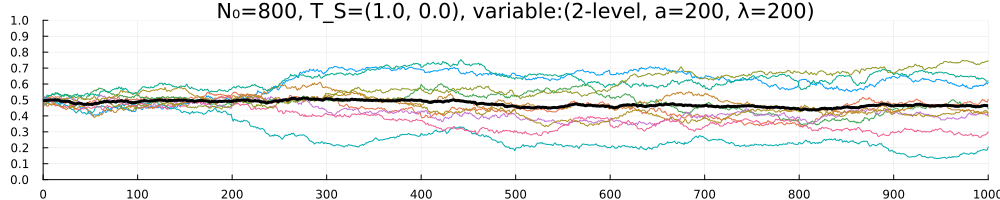

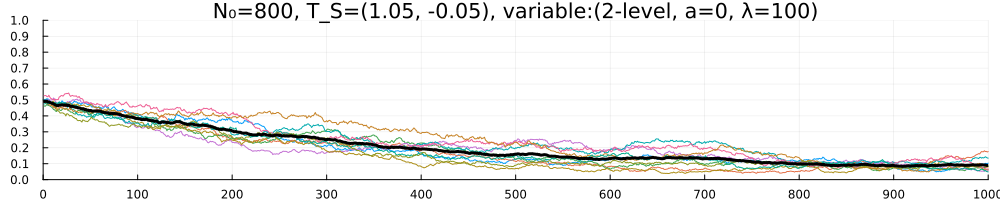

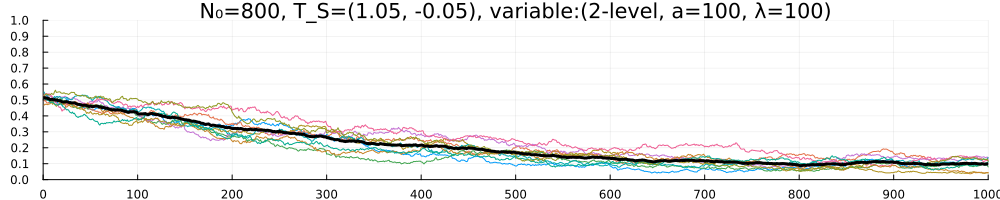

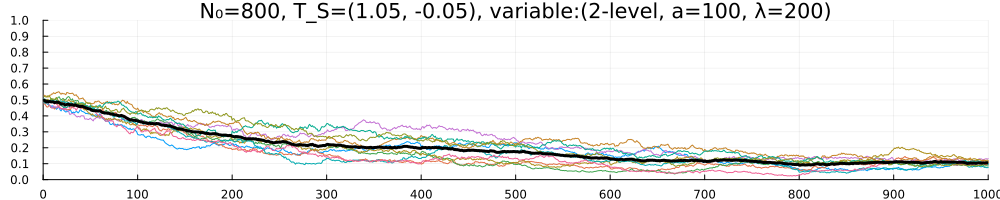

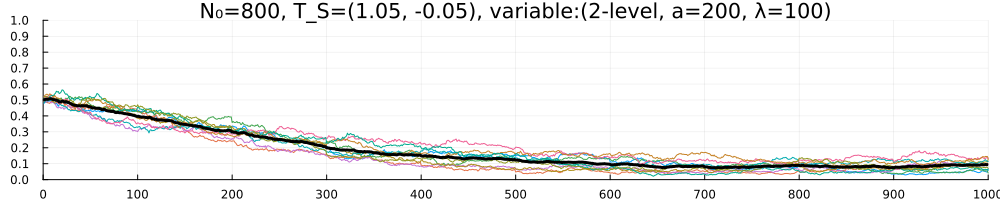

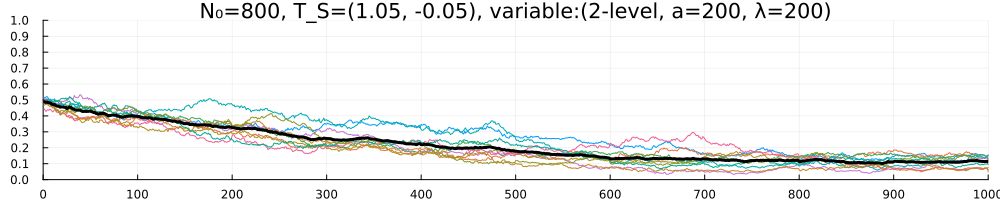

In [3]:
trial_max = 10

N_0_vec = [800]
T_S_vec = [(0.95, 0.05), (1.0, 0.0), (1.05, -0.05)]
a_vec = [0, 100, 200]
λ_vec = [100, 200]

for N_0 in N_0_vec, T_S in T_S_vec, a in a_vec, λ in λ_vec
    (a == 0 && λ > 100) && continue
    param = Param(N_0 = N_0, T = T_S[1], S = T_S[2], a = a, λ = λ, trial_max = trial_max)
    cooperation_rate_matrix = run(param)
    title = "N₀=$(N_0), T_S=$(T_S), variable:(2-level, a=$(a), λ=$(λ))"
    display(plot_time_series(cooperation_rate_matrix, title))
end

In [4]:
#==
N_vec = [250, 500]
k_vec = [200, 10]
T_vec = 0.0:0.1:2.0
S_vec = -1.0:0.1:1.0
δ_vec = [1.0]
μ_vec = [0.01]

@time open("result.csv", "w") do io
    write(io, "N,k,T,S,reproduction_rate,δ,μ,t_max,trial_max,mean_cooperation,std_cooperation\n")

    for N in N_vec, k_vec, T in T_vec, S in S_vec, δ in δ_vec
        param = Param(N = N, k = k, T = T, S = S, δ = δ, t_max = N * 2, trial_max = 10, rng = MersenneTwister(1))
        cooperation_rate_matrix = run(param)
        cooperation_rate_vec = vec(mean(cooperation_rate_matrix[end-99:end, :], dims=1))
        write(io, "$(param_to_str(param)), $(mean(cooperation_rate_vec)), $(std(cooperation_rate_vec))\n")
    end
end
==#